In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import torch

# Load the dataset
train_df = pd.read_csv("C:/cse_584/midterm/data/train_df.csv")
test_df = pd.read_csv("C:/cse_584/midterm/data/test_df.csv")

# Split the data into features (X) and target (y)
X_train = train_df[['input_text', 'generated_text']] 
y_train = train_df['model_name']  
X_test = test_df[['input_text', 'generated_text']]
y_test = test_df['model_name']



In [2]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to('cuda' if torch.cuda.is_available() else 'cpu')

# Clean the dataset to ensure all values in 'generated_text' are valid strings
X_train = X_train[X_train['generated_text'].notna()]  # Remove rows with NaN in 'generated_text'
X_train['generated_text'] = X_train['generated_text'].astype(str)  # Convert all to strings

# Function to extract BERT embeddings in batches
def get_bert_embeddings_in_batches(text_list, batch_size=32):
    all_embeddings = []
    # Process data in batches to avoid memory issues
    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i:i+batch_size]
        tokens = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt").to('cuda' if torch.cuda.is_available() else 'cpu')
        with torch.no_grad():
            outputs = bert_model(**tokens)
        # Use CLS token embedding (outputs of the first token)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(batch_embeddings)
        torch.cuda.empty_cache() # clear the cache memory to avoid memory issues
    return np.vstack(all_embeddings)

# Get BERT embeddings for both input_text and generated_text columns in batches
X_train_input_bert = get_bert_embeddings_in_batches(X_train['input_text'].tolist(), batch_size=32)
X_train_generated_bert = get_bert_embeddings_in_batches(X_train['generated_text'].tolist(), batch_size=32)
X_test_input_bert = get_bert_embeddings_in_batches(X_test['input_text'].tolist(), batch_size=32)
X_test_generated_bert = get_bert_embeddings_in_batches(X_test['generated_text'].tolist(), batch_size=32)

# Combine input and generated text embeddings
X_train_combined_bert = np.hstack([X_train_input_bert, X_train_generated_bert])
X_test_combined_bert = np.hstack([X_test_input_bert, X_test_generated_bert])


In [7]:
print(f"X_train_combined_bert shape: {X_train_combined_bert.shape}")
print(f"y_train shape: {y_train.shape}")

X_train_combined_bert shape: (59980, 1536)
y_train shape: (59980,)


In [6]:
# Align y_train with X_train_combined_bert
y_train = y_train[:X_train_combined_bert.shape[0]]


c:\Users\Raymond\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1-score: 0.7892733208618454
Classification Report:
              precision    recall  f1-score   support

        bart       0.48      0.77      0.59      1821
       bloom       0.58      0.26      0.36      1821
  distilbert       0.99      1.00      0.99      1821
     electra       0.95      0.99      0.97      1821
     flan-t5       0.88      0.79      0.83      1821
      minilm       0.99      0.99      0.99      1821

    accuracy                           0.80     10926
   macro avg       0.81      0.80      0.79     10926
weighted avg       0.81      0.80      0.79     10926



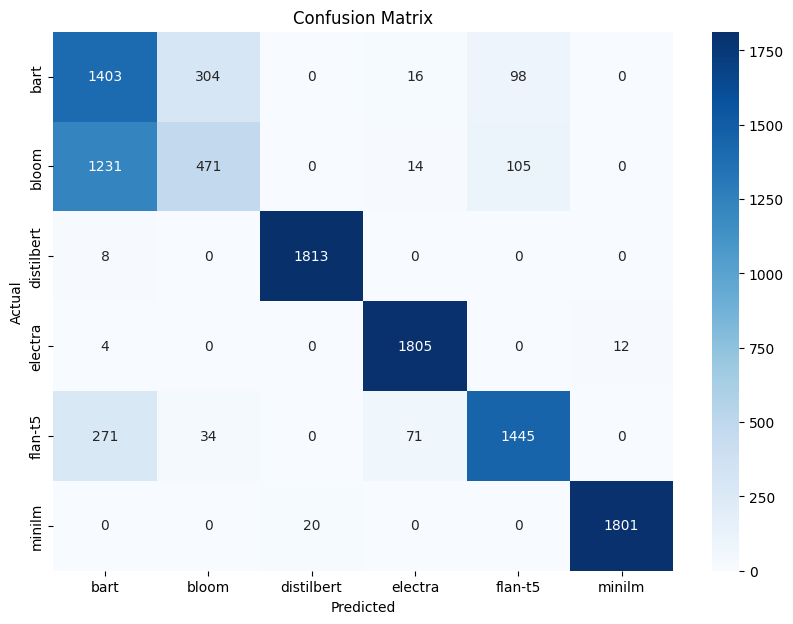

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Train a classifier (Logistic Regression in this case)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_combined_bert, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test_combined_bert)

# Evaluate with F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
